In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle
import random
import cv2

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

np.random.seed(0)

In [22]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)

with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

print(type(train_data))

x_train, y_train = train_data['features'], train_data['labels']
x_val, y_val = val_data['features'], val_data['labels']
x_test, y_test = test_data['features'], test_data['labels']



<class 'dict'>


In [23]:
print(x_train.shape)#34799 images 32*32 pixels with depth of 3
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [24]:
assert (x_train.shape[0] == y_train.shape[0]), 'The number of images is not equal to the number of labels'
assert (x_val.shape[0] == y_val.shape[0]), 'The number of images is not equal to the number of labels'
assert (x_test.shape[0] == y_test.shape[0]), 'The number of images is not equal to the number of labels'

assert(x_train.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(x_val.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'
assert(x_test.shape[1: ] == (32, 32, 3)), 'The dimensions of the images are not 32 x 32 x 3'

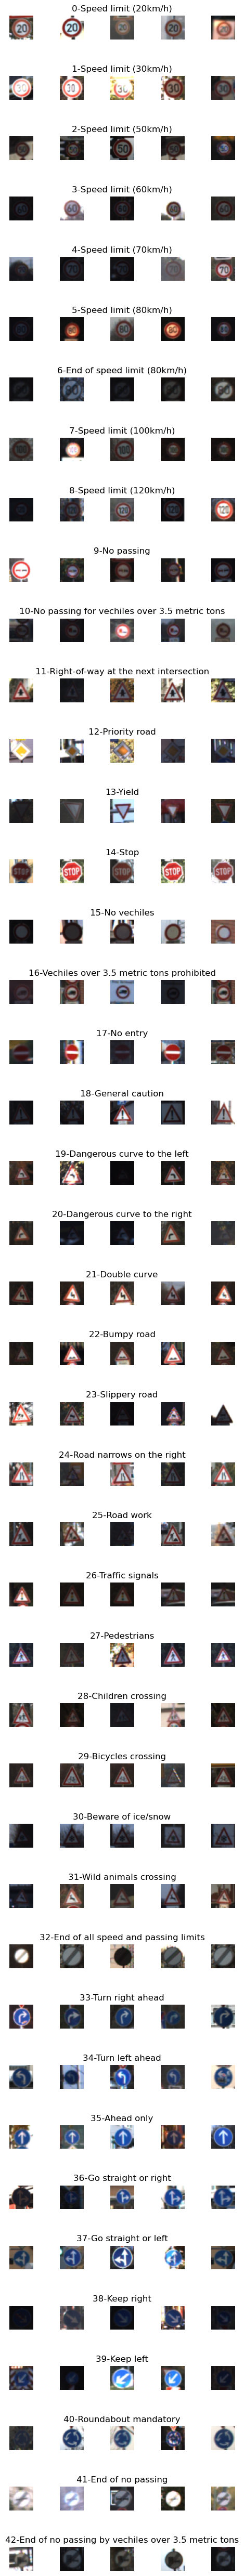

In [25]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = x_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ '-' + row['SignName'])
            num_of_samples.append(len(x_selected))


[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

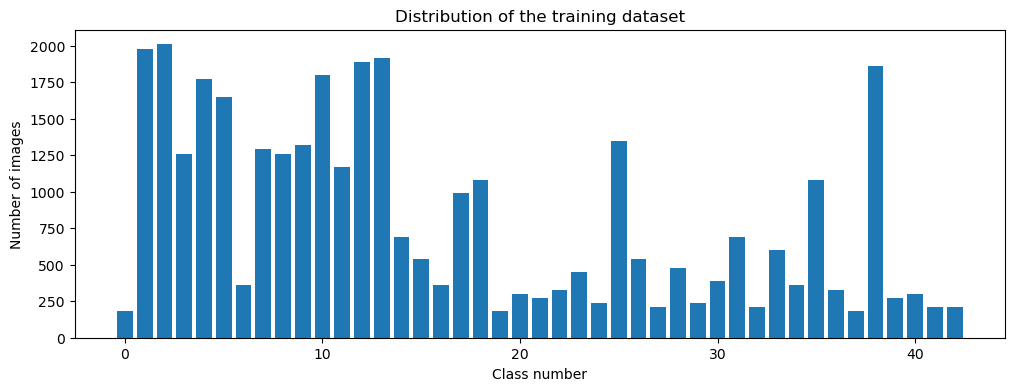

In [26]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")


(32, 32, 3)
36


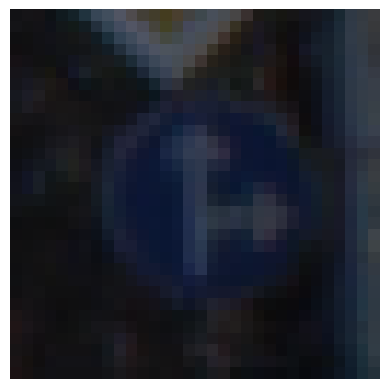

In [27]:
plt.imshow(x_train[1000], interpolation='none')
plt.axis('off')
print(x_train[1000].shape)
print(y_train[1000])

(32, 32)


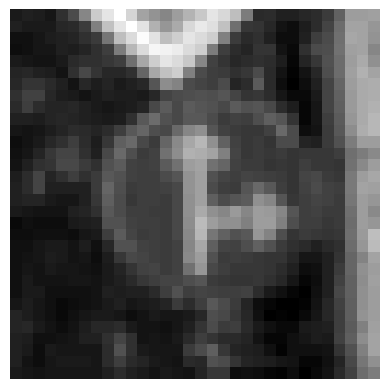

In [28]:
def gray_scale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = gray_scale(x_train[1000])
plt.imshow(img, cmap='gray', interpolation='none')
plt.axis('off')
print(img.shape)


(32, 32)


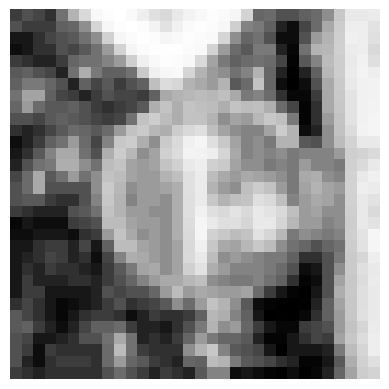

In [29]:
def equalize(img):#only accepts gray scale images
    img = cv2.equalizeHist(img)#only accepts gray scale images
    return img

img = equalize(gray_scale(x_train[1000]))
plt.imshow(img, cmap='gray', interpolation='none')
plt.axis('off')
print(img.shape)

In [30]:
def preprocessing(img):
    img = gray_scale(img)
    img = equalize(img)
    img = img/255
    return img

x_train = np.array(list(map(preprocessing, x_train)))
x_val = np.array(list(map(preprocessing, x_val)))
x_test = np.array(list(map(preprocessing, x_test)))


(34799, 32, 32)


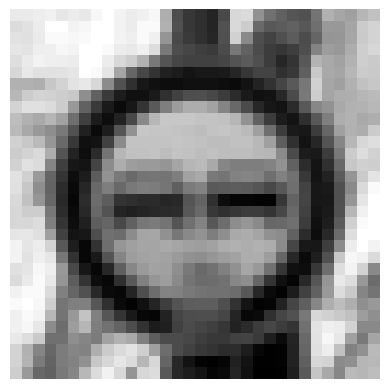

In [31]:
plt.imshow(x_train[random.randint(0, (len(x_train) - 1))], cmap='gray', interpolation='none')
plt.axis('off')
print(x_train.shape)

In [32]:
x_train = x_train.reshape(34799, 32, 32, 1)
x_val = x_val.reshape(4410, 32, 32, 1)
x_test = x_test.reshape(12630, 32, 32, 1)

In [33]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [34]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [35]:
def modified_model():
    model =Sequential()
    model.add(Conv2D(60, (5, 5), input_shape = (32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))    
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))

    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics = ['accuracy'])
    return model

In [36]:
model = modified_model()
print(model.summary())

c:\Users\3omd4\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [37]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), batch_size=400, verbose=1, shuffle=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 40s 420ms/step - accuracy: 0.1492 - loss: 3.2226 - val_accuracy: 0.7730 - val_loss: 0.8627
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 405ms/step - accuracy: 0.6998 - loss: 0.9558 - val_accuracy: 0.8825 - val_loss: 0.3649
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 400ms/step - accuracy: 0.8498 - loss: 0.4800 - val_accuracy: 0.9261 - val_loss: 0.2431
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 441ms/step - accuracy: 0.8982 - loss: 0.3265 - val_accuracy: 0.9465 - val_loss: 0.1709
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 453ms/step - accuracy: 0.9260 - loss: 0.2410 - val_accuracy: 0.9546 - val_loss: 0.1567
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 32s 372ms/step - accuracy: 0.9355 - loss: 0.1984 - val_accuracy: 0.9540 - val_loss: 0.1521
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 38s 436ms/step - accuracy: 0.9440 - loss: 0.1747 - val_accuracy: 0.9662 - val_loss: 0.1104
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 35s 399ms/step - accuracy: 0.9526 - loss: 0.1460 - val_accu

Text(0.5, 0, 'epochs')

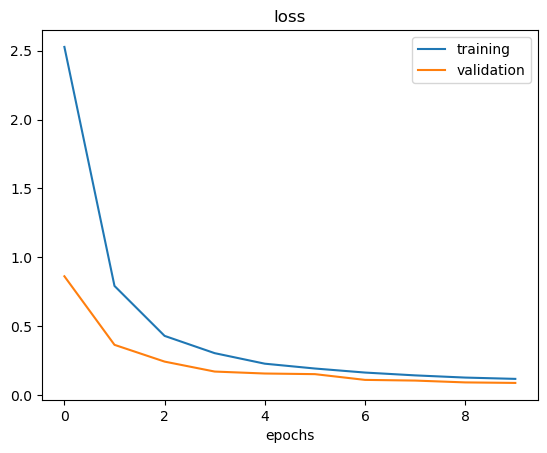

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

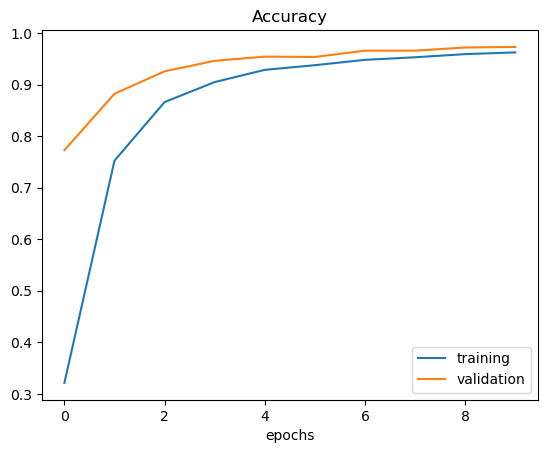

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epochs')

In [40]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.14215217530727386
Test Accuracy: 0.958748996257782


In [49]:
import requests
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

def preprocessing(img):
    # Add your preprocessing steps here
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img / 255.0  # Normalize the image
    return img

def TEST(url):
    r = requests.get(url, stream=True)
    img = Image.open(r.raw)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

    img = np.asarray(img)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()
    print(img.shape)

    img = img.reshape(1, 32, 32, 1)

    predictions = model.predict(img)
    predicted_class = np.argmax(predictions, axis=1)
    print("predicted sign: " + str(predicted_class))
    return img

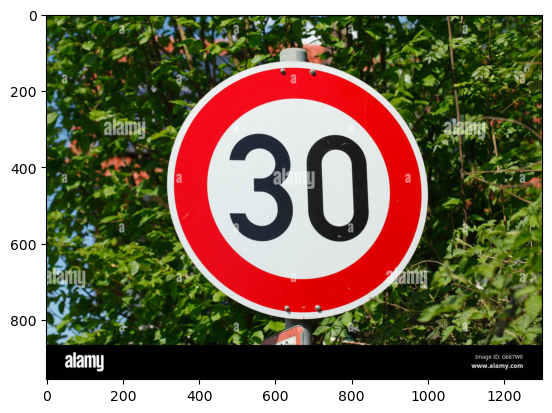

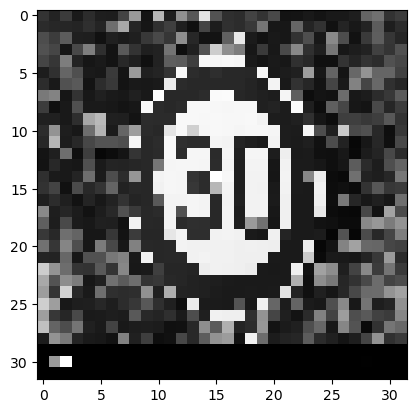

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
predicted sign: [1]


In [ ]:
url ='https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
img = TEST(url)

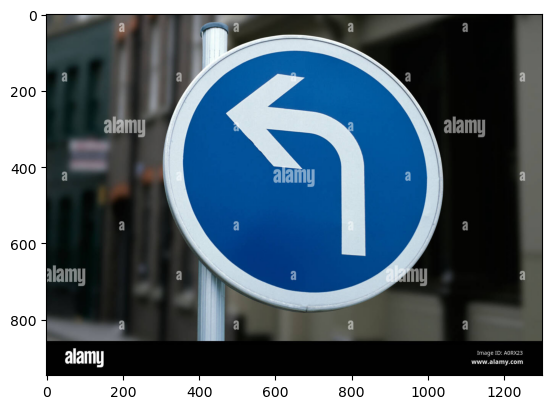

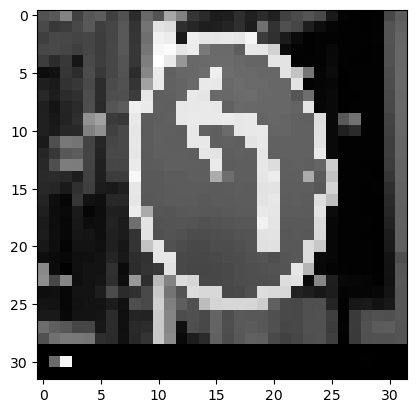

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicted sign: [5]


In [55]:
url ="https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg"
img = TEST(url)

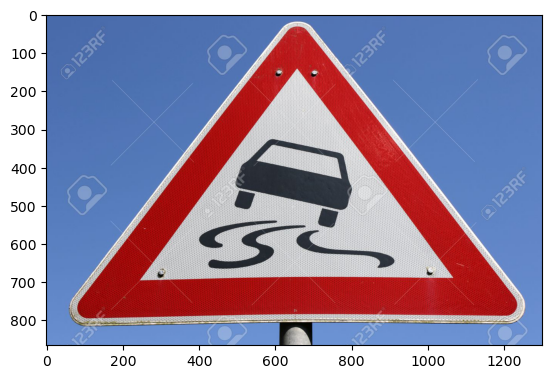

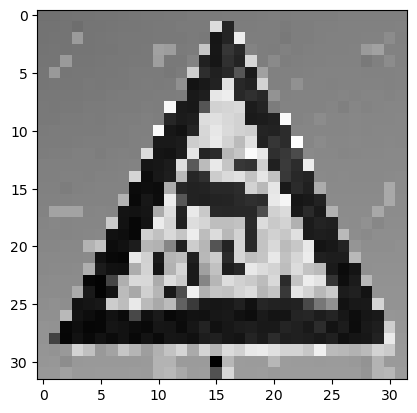

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted sign: [23]


In [52]:
url ="https://previews.123rf.com/images/bwylezich/bwylezich1608/bwylezich160800375/64914157-german-road-sign-slippery-road.jpg"
img = TEST(url)

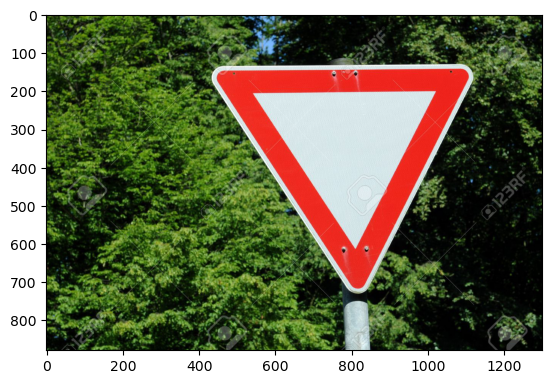

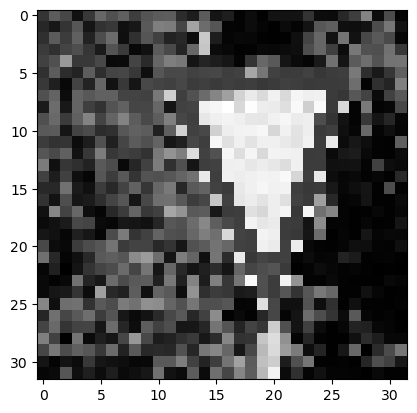

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicted sign: [13]


In [53]:
url ="https://previews.123rf.com/images/pejo/pejo0907/pejo090700003/5155701-german-traffic-sign-no-205-give-way.jpg"
img = TEST(url)

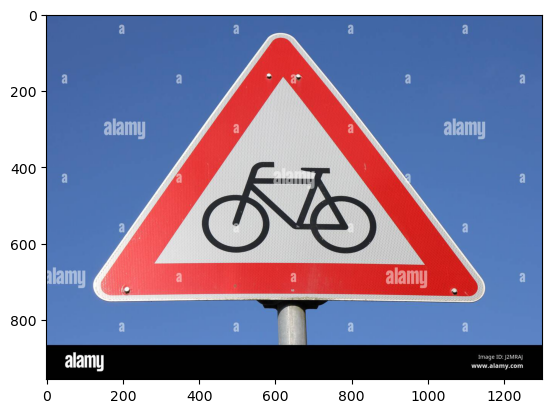

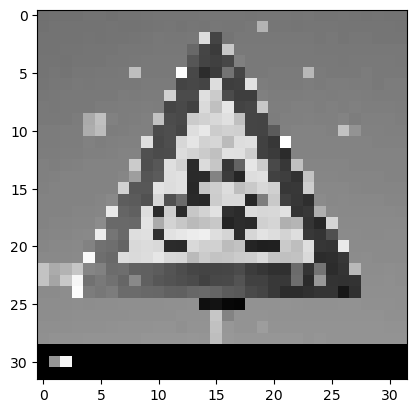

(32, 32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted sign: [25]


In [54]:
url ="https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg"
img = TEST(url)